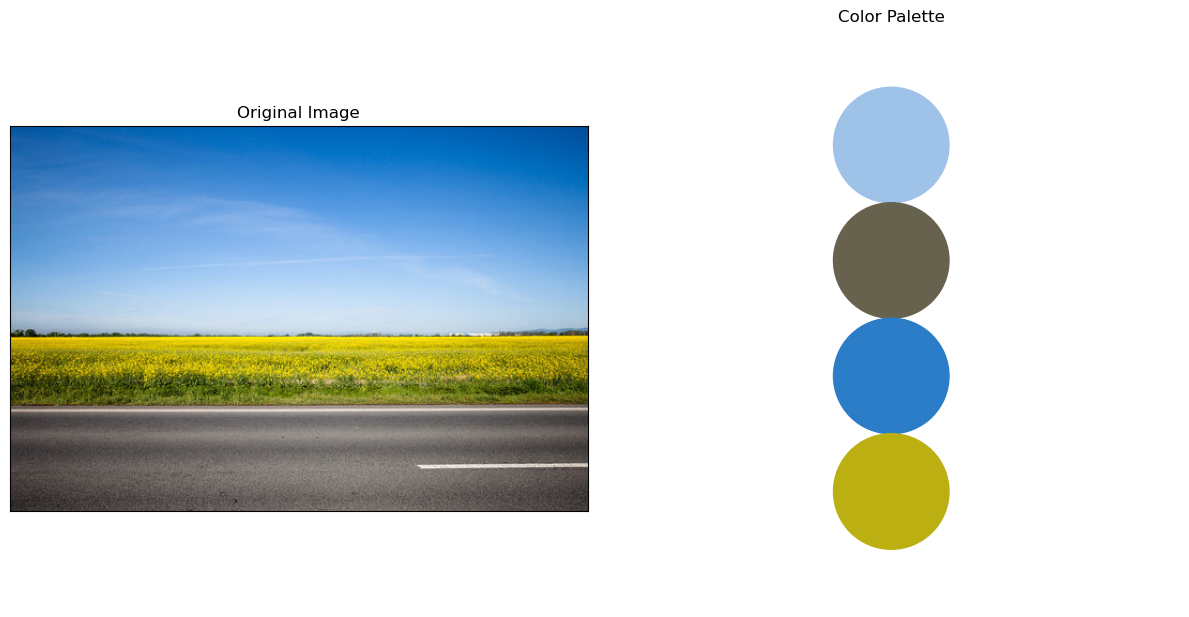

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from PIL import Image

def generate_color_palette(image_path, n_clusters=4):
    # Load the image
    img = Image.open(image_path)
    data = np.asarray(img, dtype="int32")

    # Reshape and normalize image data
    points = data.reshape(-1, 3) / 255.0

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(points)
    labels = kmeans.labels_

    # Create the figure for visualization
    fig, ax = plt.subplots(1, 2, figsize=(12, 12))

    # Original image
    ax[0].imshow(img)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title("Original Image")

    # Generate color palette circles
    ax[1].set_xlim(0, 1)
    ax[1].set_ylim(0, 1)
    ax[1].set_aspect('equal', adjustable='box')
    ax[1].axis('off')
    ax[1].set_title("Color Palette")

    for i in range(n_clusters):
        # Get the cluster's average color
        mask = (labels == i)
        avg_color = points[mask].mean(axis=0)

        # Add a circle representing the color
        circle = plt.Circle((0.5, 1 - (i + 1) / (n_clusters + 1)), 0.1, color=avg_color)
        ax[1].add_artist(circle)

    plt.tight_layout()

    return fig

image_path = "images/img_1.jpg"
fig = generate_color_palette(image_path)
fig.savefig("output_palette.png")  # Save the figure if needed


# Create Base Interface

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from PIL import Image
import gradio as gr
import io

def generate_color_palette(image, n_clusters=4):
    # Load the image
    img = Image.open(image)
    data = np.asarray(img, dtype="int32")
    
    # Reshape and normalize image data
    points = data.reshape(-1, 3) / 255.0
    
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(points)
    labels = kmeans.labels_
    
    # Create the figure for visualization
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Original image
    ax[0].imshow(img)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title("Original Image")
    
    # Generate color palette circles
    ax[1].set_xlim(0, 1)
    ax[1].set_ylim(0, 1)
    ax[1].set_aspect('equal', adjustable='box')
    ax[1].axis('off')
    ax[1].set_title("Color Palette")
    
    # Create color palette
    colors = []
    for i in range(n_clusters):
        mask = (labels == i)
        avg_color = points[mask].mean(axis=0)
        colors.append(avg_color)
        circle = plt.Circle((0.5, 1 - (i + 1) / (n_clusters + 1)), 0.1, color=avg_color)
        ax[1].add_artist(circle)
        
        # Add color values as text
        rgb = tuple(int(c * 255) for c in avg_color)
        hex_color = '#{:02x}{:02x}{:02x}'.format(*rgb)
        ax[1].text(0.65, 1 - (i + 1) / (n_clusters + 1), hex_color, 
                  verticalalignment='center')
    
    plt.tight_layout()
    
    # Convert plot to numpy array
    fig.canvas.draw()
    img_array = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img_array = img_array.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    plt.close(fig)
    return img_array

# Gradio interface
def process_image(image, n_clusters):
    return generate_color_palette(image, n_clusters)

iface = gr.Interface(
    fn=process_image,
    inputs=[
        gr.Image(type="filepath", label="Upload an Image"),
        gr.Slider(minimum=2, maximum=10, step=1, value=4, label="Number of Colors")
    ],
    outputs=gr.Image(type="numpy", label="Color Palette"),
    title="Image Color Palette Generator",
    description="Upload an image to extract its dominant color palette using KMeans clustering. The visualization shows the original image and the extracted colors with their hex codes.",
    examples=[["images/img_1.jpg", 4]]  # Add your own example images here
)

if __name__ == "__main__":
    iface.launch()

Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


C:\Users\EL AIDI MOHAMED\AppData\Local\Temp\ipykernel_21944\4165857805.py:55: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img_array = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


# Improve the Interface

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans
from PIL import Image
import gradio as gr
import colorsys
from matplotlib.colors import rgb2hex
from matplotlib import font_manager

def rgb_to_hsv(rgb):
    return colorsys.rgb_to_hsv(rgb[0], rgb[1], rgb[2])

def generate_color_palette(
    image, 
    n_clusters=4, 
    clustering_method="kmeans",
    sort_by="prominence",
    color_format="all",
    dark_mode=False
):
    # Load and process image
    img = Image.open(image)
    data = np.asarray(img, dtype="int32")
    points = data.reshape(-1, 3) / 255.0
    
    # Choose clustering method
    if clustering_method == "kmeans":
        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    else:
        clusterer = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
    
    # Fit clustering
    clusterer.fit(points)
    labels = clusterer.labels_
    
    # Get colors and their prominence
    colors = []
    prominences = []
    for i in range(n_clusters):
        mask = (labels == i)
        avg_color = points[mask].mean(axis=0)
        prominence = np.sum(mask) / len(labels)
        colors.append(avg_color)
        prominences.append(prominence)
    
    # Sort colors
    if sort_by == "prominence":
        sorted_indices = np.argsort(prominences)[::-1]
    elif sort_by == "hue":
        hsv_colors = [rgb_to_hsv(color) for color in colors]
        sorted_indices = np.argsort([hsv[0] for hsv in hsv_colors])
    else:  # brightness
        sorted_indices = np.argsort([np.mean(color) for color in colors])[::-1]
    
    colors = [colors[i] for i in sorted_indices]
    prominences = [prominences[i] for i in sorted_indices]
    
    # Set background color based on mode
    bg_color = '#1a1a1a' if dark_mode else 'white'
    text_color = 'white' if dark_mode else 'black'
    
    # Create enhanced visualization
    fig = plt.figure(figsize=(15, 6), facecolor=bg_color)
    plt.style.use('default')
    
    # Add background
    plt.fill_between([-0.1, 1.1], -0.1, 1.1, color=bg_color)
    
    # Main color blocks
    for i, (color, prominence) in enumerate(zip(colors, prominences)):
        # Calculate position for vertical color blocks
        left = i / n_clusters
        width = 1 / n_clusters
        
        # Add main color block
        plt.axvspan(left, left + width, 0.3, 1.0, 
                   color=color, 
                   edgecolor='none',
                   alpha=1.0)
        
        # Generate text colors for optimal contrast
        brightness = np.mean(color)
        block_text_color = 'white' if brightness < 0.6 else 'black'
        
        # Format color values
        rgb = tuple(int(c * 255) for c in color)
        hex_color = rgb2hex(color)
        
        # Create formatted text based on selection
        if color_format == "all":
            color_text = f"RGB {rgb}\n{hex_color}"
        elif color_format == "rgb":
            color_text = f"RGB {rgb}"
        else:  # hex
            color_text = hex_color
            
        # Add prominence percentage
        pct_text = f"{prominence:.1%}"
        
        # Position and add text
        plt.text(left + width/2, 0.85, color_text,
                ha='center', va='center',
                color=block_text_color,
                fontsize=10,
                fontweight='bold',
                fontfamily='monospace')
        
        plt.text(left + width/2, 0.65, pct_text,
                ha='center', va='center',
                color=block_text_color,
                fontsize=12,
                fontweight='bold')
        
        # Add small color box with hex code in theme colors below
        plt.text(left + width/2, 0.15,
                f"#{int(color[0]*255):02x}{int(color[1]*255):02x}{int(color[2]*255):02x}",
                ha='center', va='center',
                color=text_color,
                fontsize=10,
                fontfamily='monospace')
        
    # Remove axes and make plot clean
    plt.axis('off')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    
    # Convert to numpy array
    fig.canvas.draw()
    img_array = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img_array = img_array.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    plt.close(fig)
    return img_array

# Gradio interface
def process_image(image, n_clusters, clustering_method, sort_by, color_format, dark_mode):
    return generate_color_palette(
        image,
        n_clusters,
        clustering_method,
        sort_by,
        color_format,
        dark_mode
    )

# Create interface with theme selection
with gr.Blocks(theme=gr.themes.Soft()) as iface:
    gr.Markdown("# Modern Color Palette Generator")
    gr.Markdown("Extract beautiful color palettes from your images with precise color codes and prominence percentages.")
    
    with gr.Row():
        with gr.Column(scale=3):
            input_image = gr.Image(type="filepath", label="Upload Image")
            n_clusters = gr.Slider(
                minimum=2,
                maximum=10,
                step=1,
                value=4,
                label="Number of Colors"
            )
        
        with gr.Column(scale=2):
            clustering_method = gr.Radio(
                choices=["kmeans", "minibatch"],
                value="kmeans",
                label="Clustering Method",
                info="MiniBatch is faster for large images"
            )
            sort_by = gr.Radio(
                choices=["prominence", "hue", "brightness"],
                value="prominence",
                label="Sort Colors By",
                info="Choose how to order the extracted colors"
            )
            color_format = gr.Radio(
                choices=["all", "rgb", "hex"],
                value="all",
                label="Color Format",
                info="Choose how color values are displayed"
            )
            dark_mode = gr.Checkbox(
                label="Dark Mode",
                info="Toggle between dark and light theme"
            )
    
    output_image = gr.Image(type="numpy", label="Color Palette")
    
    # Process button
    process_btn = gr.Button("Generate Palette", variant="primary")
    process_btn.click(
        fn=process_image,
        inputs=[input_image, n_clusters, clustering_method, sort_by, color_format, dark_mode],
        outputs=output_image
    )

if __name__ == "__main__":
    iface.launch()

Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.


C:\Users\EL AIDI MOHAMED\AppData\Local\Temp\ipykernel_21944\2297135733.py:76: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axvspan(left, left + width, 0.3, 1.0,
C:\Users\EL AIDI MOHAMED\AppData\Local\Temp\ipykernel_21944\2297135733.py:128: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img_array = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
